In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chisquare
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# sharper plots
%config InlineBackend.figure_format = 'retina'

In [109]:
# T-Test for Ficher criteria and Chi-squared
def smart_test(df: pd.DataFrame):
    # Ficher criteria
    if (df.shape[0] * df.shape[1] == 4):
        if (df.values < 5).any():
            return fisher_exact(df)[1]
    # Chi-squared
    dfree = (df.shape[0] - 1) * (df.shape[1] - 1)
    return list(chisquare(df, axis=None)), dfree

In [110]:
df = pd.DataFrame([{'A': 3, 'B': 7}, {'A':6, 'B': 7}])
print(smart_test(df))

0.6692690806299642


In [232]:
def most_significant(df: pd.DataFrame):
    min_p_index = chisquare(df, axis=0).pvalue.argmin()
    return df.iloc[:,min_p_index].name

In [233]:
test_data = pd.read_csv("data/test_data.csv")
df = pd.DataFrame()
for column in test_data.columns:
    df[column] = test_data[column].value_counts()
df

,V1,V2,V3
G,10,10,6
T,7,5,9
C,7,9,4
A,6,6,11


In [234]:
print(most_significant(df))

V3


### Create feature "important_cases" for iris dataset


In [255]:
from sklearn import datasets

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
comparisons = (iris_df > iris_df.mean(axis=0)).sum(axis=1)
iris_df["important_cases"] = "No"
iris_df.loc[comparisons >= 3, "important_cases"] = "Yes"

In [256]:
def get_important_cases(df: pd.DataFrame):
    comparisons = (df > df.mean(axis=0)).sum(axis=1)
    df["important_cases"] = "No"
    df.loc[comparisons > df.shape[1] / 2, "important_cases"] = "Yes"

In [111]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [3]:
def max_resid(df: pd.DataFrame):
    table = sm.stats.Table(pd.crosstab(df.columns[0], df.columns[1]))
    return table.standardized_resids.argmax() # index of max residuals

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
df_train = pd.read_csv('data/titanic/train.csv')
df_train['sex_cod'] = LabelEncoder().fit_transform(df_train.Sex)  # кодировка переменной "пол" (0, 1)
x_train = df_train.sex_cod.values.reshape(-1, 1)  # преобразование списка в список списков
y_train = df_train.Survived
logreg = LogisticRegression()
model = logreg.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

[[-2.44597988]]
[1.01628767]


In [30]:
def get_coefficients(df: pd.DataFrame):
    X = df.drop(columns=df.columns[-1])
    Y = df[df.columns[-1]]
    model = LogisticRegression().fit(X, Y)
    return np.r_[model.intercept_, model.coef_.flatten()]

In [31]:
df = pd.read_csv("data/test_data_01.csv")
get_coefficients(df)

array([0.20081457, 0.02267641])

In [37]:
def centered(df: pd.DataFrame, varss:list):
    for var in varss:
        df[var] = df[var] - df[var].mean()
    return df

In [38]:
centered(pd.read_csv("https://stepic.org/media/attachments/course/524/cen_data.csv"), ["X4", "X2", "X1"])

,X1,X2,X3,X4
0,-1.04,-1.2,10.7,-0.62
1,-1.44,1.9,9.7,1.68
2,0.06,-3.5,8.4,1.78
3,0.06,0.0,7.7,-2.92
4,2.36,2.8,12.3,0.08


In [222]:
def get_features(df: pd.DataFrame, depvar:str, printsum=False):
    results = []
    # Put numeric categories instead of objects
#     obj_cols = df.select_dtypes(['object']).columns
#     for col in obj_cols:
#         df[col] = LabelEncoder().fit(df[col]).transform(df[col])
    
    X = df.drop(depvar, axis=1)
    Y = df[depvar].to_frame()
#     Y[depvar] = LabelEncoder().fit(Y).transform(Y)

#     log_reg = sm.Logit(Y, X).fit()
#     model = LogisticRegression().fit(X, Y)
#     params = [model.intercept_, model.coef_] 

    logit_res = sf.glm(f'C({depvar}) ~ C(type) + weight + length + width', df, family = sm.families.Binomial()).fit()
    print(logit_res.summary()) if printsum else ""
    p = 0
    results.append(logit_res.pvalues.loc[logit_res.pvalues < 0.05].index.tolist())
    return results if len(results) > 1 else "Prediction makes no sense"

In [223]:
df = pd.read_csv("https://stepic.org/media/attachments/course/524/test_luggage_1.csv")
get_features(df, "is_prohibited")

'Prediction makes no sense'

### Predictions

In [217]:
train_df = pd.read_csv("https://stepic.org/media/attachments/course/524/test_data_passangers.csv")
test_df = pd.read_csv("https://stepic.org/media/attachments/course/524/predict_passangers.csv")

In [247]:
def get_passenger_with_max_suspection(train_df: pd.DataFrame, test_df: pd.DataFrame):
    logit_reg = sf.glm('C(is_prohibited) ~ C(type) + weight + length + width', train_df, family = sm.families.Binomial()).fit()
    id_max_is_prohib = logit_reg.predict(test_df).idxmax()
    return test_df.iloc[id_max_is_prohib,:]["passangers"]

In [248]:
print(get_passenger_with_max_suspection(train_df, test_df))

Vsevolod


In [18]:
from scipy.stats import shapiro
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [19]:
def gauss_test(df: pd.DataFrame):
    return [shapiro(df[col]).pvalue for col in df.columns if is_numeric_dtype(df[col])]

In [20]:
df_gauss_test = pd.read_csv("https://stepic.org/media/attachments/course/524/test.csv")
print(gauss_test(df_gauss_test))
df_gauss_test.head()

[0.5682080984115601, 0.24583366513252258, 0.31419050693511963, 0.00937374122440815]


,V1,V2,V3,V4,V5,V6
0,10.03,s,9.35,s,9.91,11.23
1,12.45,x,11.61,x,10.07,6.41
2,9.97,a,7.02,a,8.85,11.38
3,10.53,f,12.24,f,7.22,8.71
4,6.59,b,7.72,b,14.31,10.08


## Smart ANOVA

In [17]:
from scipy.stats import kruskal
from scipy.stats import bartlett
from scipy.stats import f_oneway
from scipy.stats import levene # optional, use on significantly non-normal distributions


In [15]:
def smart_anova(df: pd.DataFrame):
    res = []
    cat_df = [df[df['y'] == cat] for cat in df['y'].unique()]
    # Gauss distribution test
    gauss_p_lst = [gauss_test(df) for df in cat_df]
    # Bartlett dispersion test
    bartlett_p = bartlett(cat_df[0]['x'], cat_df[1]['x'], cat_df[2]['x'])
    normal = True
    for gauss_p in gauss_p_lst:
            for p in gauss_p:
                if p < 0.05:
                    normal = False
    if (bartlett_p.pvalue > 0.05) & normal:
        return pd.Series(data=f_oneway(cat_df[0]['x'], cat_df[1]['x'], cat_df[2]['x']).pvalue, index=["ANOVA"])
    else:
        return pd.Series(data=kruskal(cat_df[0]['x'], cat_df[1]['x'], cat_df[2]['x']).pvalue, index=["KW"])
    

In [22]:
df_anova = pd.read_csv("https://stepic.org/media/attachments/course/524/s_anova_test.csv")
print(smart_anova(df_anova))

ANOVA    0.265298
dtype: float64


### normality_by

In [409]:
def normality_by(df):
    return df.groupby(['y', 'z'])['x'].apply(lambda x: shapiro(x).pvalue)

In [411]:
df_normality_by = pd.read_csv("https://stepic.org/media/attachments/course/524/test_for_norm.csv")
print(normality_by(df_normality_by))


y  z
0  2    0.219766
   3    0.623818
1  2    0.196036
   3    0.047823
Name: x, dtype: float64


In [413]:
from sklearn import datasets

In [414]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris["data"], columns=iris["feature_names"])

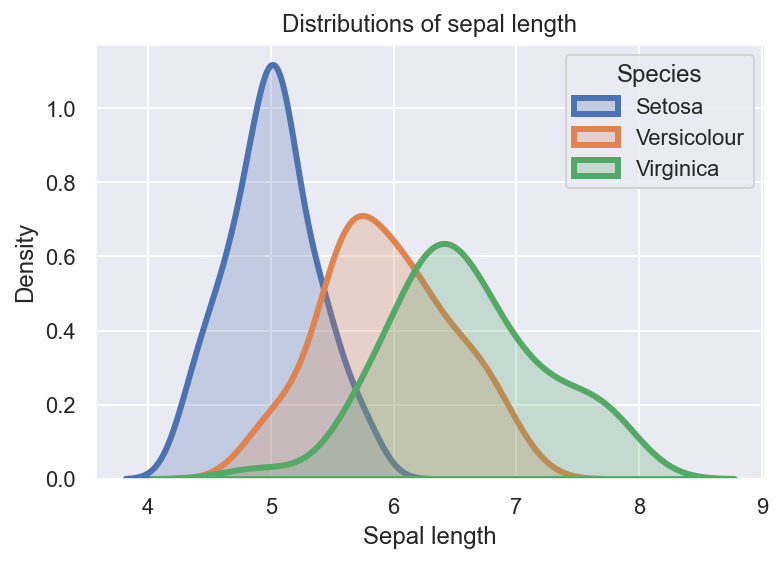

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

iris = datasets.load_iris()
X = iris.data[:, :1]  # sepal length
y = iris.target
labels = ["Setosa", "Versicolour", "Virginica"]

for i in range(3):
    sns.distplot(X[y==i], hist = False, kde = True,
     kde_kws = {'shade': True, 'linewidth': 3},
     label=labels[i])
plt.xlabel("Sepal length")
plt.ylabel("Density")
plt.title("Distributions of sepal length")
plt.legend(title="Species");

## Clustering and PCA

In [140]:
from sklearn.cluster import AgglomerativeClustering

In [9]:
def smart_hclust(df: pd.DataFrame, n_clusters:int):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    df["cluster"] = cluster.fit_predict(df).astype(np.object)

In [10]:
df_cluster = pd.read_csv("https://stepic.org/media/attachments/course/524/test_data_hclust.csv")
smart_hclust(df_cluster, 3)
df_cluster

,X1,X2,X3,X4,X5,cluster
0,11,7,10,10,8,0
1,9,10,10,8,6,0
2,9,2,12,14,11,0
3,9,11,8,10,3,0
4,7,9,10,11,14,0
5,9,11,9,6,9,0
6,16,20,22,19,16,1
7,23,18,21,24,16,1
8,15,21,14,21,21,2
9,19,20,15,17,17,2


In [59]:
def get_difference(df: pd.DataFrame, n_clusters:int):
    res = []
    smart_hclust(df, n_clusters)
    clusters = [df[df['cluster'] == cat] for cat in df['cluster'].unique()]
    anova = f_oneway(clusters[0].drop("cluster", axis=1), clusters[1].drop("cluster", axis=1)).pvalue < 0.05
    res.append(anova)
    return df.drop("cluster", axis=1).columns[anova] # Filter columns based on ANOVA results

In [61]:
df_cluster_gd = pd.read_csv("https://stepic.org/media/attachments/course/524/cluster_1.csv")
print(get_difference(df_cluster_gd, 2))
df_cluster_gd = pd.read_csv("https://stepic.org/media/attachments/course/524/cluster_2.csv")
print(get_difference(df_cluster_gd, 2))

Index(['V2'], dtype='object')
Index(['V1', 'V2'], dtype='object')


In [62]:
from sklearn.decomposition import PCA

In [87]:
def get_pc(df: pd.DataFrame):
    pca = PCA(n_components=2)
    pca.fit(df)
    for idx, pc in enumerate(pca.components_):
        df["PC"+str(idx+1)] = pca.components_[idx]
    return df

In [88]:
df_pca = pd.read_csv("https://stepic.org/media/attachments/course/524/pca_test.csv")
print(get_pc(df_pca))

   V1  V2  V3  V4  V5       PC1       PC2
0  13  15  12  13  12  0.027071  0.504477
1  16  11   8  12   6 -0.127574 -0.764549
2  15   7  10  12  13 -0.513338 -0.229197
3  12  11   6   6   4 -0.396689  0.293058
4  11  13  13  10  12 -0.749742  0.150179


In [138]:
def get_pca2(df: pd.DataFrame, threshold:float):
    pca = PCA(n_components=df.shape[1])
    fit = pca.fit_transform(df)
    n_components = sum(np.cumsum(pca.explained_variance_ratio_) < threshold) + 1
    return pd.concat([df, pd.DataFrame(fit[:, :n_components])], axis=1)


In [139]:
df_pca2 = pd.read_csv("data/swiss.csv")
get_pca2(df_pca2.drop("Location", axis=1), 0.90).head()


,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality,0,1
0,80.2,17.0,15,12,9.96,22.2,-37.032433,17.434879
1,83.1,45.1,6,9,84.84,22.2,42.797334,14.687668
2,92.5,39.7,5,5,93.40,20.2,51.081639,19.274036
3,85.8,36.5,12,7,33.77,20.3,-7.716707,5.458722
4,76.9,43.5,17,15,5.16,20.6,-35.032658,-5.126097


## Multicollinearity check

In [ ]:
def is_multicol(df: pd.DataFrame):
    
    s
    return 